# ECON 570 Assignment 2
## Angelo Carrasco
### USC ID: 6630386317
### Spring 2022

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
random.seed(10)

In [2]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [3]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [4]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.8*C+err  
    
    if flagX==False and conf==False:
        return (Yab,T)
    elif flagX==False and conf==True:     
        return (Yab,T,C)
    elif flagX==True and conf==False:
        return (Yab,T,X[:,:p0])
    else:                
        return (Yab,T,C,X[:, :p0])

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

# Question 1
## Outcome Depends on Treatments and Covariates
$Y_i = \tau*T_i+\beta'*X_i+e_i$

### Illustrate DGP with DAG

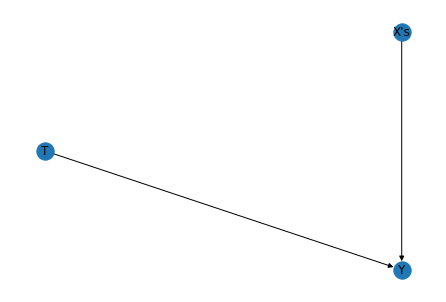

In [5]:
g = nx.DiGraph()
g.add_edge('T','Y')
g.add_edge("X's",'Y')
nx.draw(g, pos=nx.shell_layout(g), with_labels=True)

### Simulate the DGP

In [6]:
tau = 2
corr = .5
conf=False
p = 20
p0 = 10 # number of covariates used in the DGP
flagX = True
for N in [100,1000]:
    genData = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
    data1 = pd.DataFrame(np.concatenate((genData[0],genData[1],genData[2]),axis=1))
    data1.to_csv('data1n'+str(N)+'.csv')

### Part a): Coviariates not controlled for

In [19]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 188.97it/s]


In [20]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.030877822009991448, RMSE=7.860085055182795, size=0.05
N=1000: bias=-0.055798886400580186, RMSE=2.6018045208799148, size=0.048


### Part b): Coviariates are controlled for

In [21]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xcov = X[:,:p0]
        model = sm.OLS(Yexp, np.concatenate((T,Xcov),axis=1))
        results = model.fit()
        tauhat = results.params[0]
        se_tauhat = results.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 171.08it/s]


In [22]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.006988125955574704, RMSE=0.14911628645379219, size=0.054
N=1000: bias=-0.00017757247943009502, RMSE=0.043568446303068706, size=0.045


The difference between the two situations is wuite clear. The bias in both sample sizes for scenario b) was far smaller than that of scenario A. Similarly, the root mean squared error for scenario b) was far smaller than that of scenario a), with the difference being quite large for N=100. Since size is calculated as the number of standard deviations tauhat is away from the true tau, we are looking for smaller sizes as more accureate estimations of tau. In the case of N=1000, there is a noticable difference of .1 standard deviations, with scenario b) being closer to tau. In the case of N=100, we that scenario a) was closer to tau, but this can be expected, since N=100 can be considered an asymptotically small sample size (thus estimates may not be as accurate).

### Real Life Example

T: Gender

X's: GPA, Sports, Jobs, Bilingual, etc.

Y: Admission to College


We wish to know the effect of Gender on college admissions, so we use a gender dummy variable as the treatment variable. Other factors also affect college admissions such as a candidate's GPA, sports played, Jobs/interships held, and cultural varaibles such as being bilingual. It is reasonable to assume that none of these variables dtermine/cause the candidate's gender, so this situation fits the scenario for question 1. 

# Question 2
## Simulate DGP with a confounder
$Y_i = \tau*T_i+\beta*C+e_i$ 

### Illustrate DGP with DAG

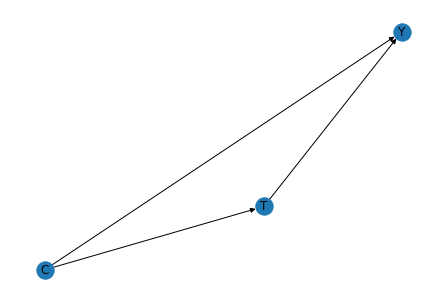

In [23]:
g2 = nx.DiGraph()
g2.add_edge('C','T')
g2.add_edge('T','Y')
g2.add_edge('C','Y')
nx.draw(g2, pos=nx.spiral_layout(g2), with_labels=True)

### Simulate DGP
$y_i = \tau*T_i+\beta'*c_i+e_i$

In [73]:
tau2 = 4
corr2 = .5
conf2=True
p2 = 5
p02 = 0 # number of covariates used in the DGP
flagX2 = False
for N in [100,1000]:
    genData = fn_generate_data(tau2,N,p2,p02,corr2,conf2,flagX2)
    data2 = pd.DataFrame(np.concatenate((genData[0],genData[1],genData[2]),axis=1))
    data2.columns = ['Y','T','C']
    data2.to_csv('data2n'+str(N)+'.csv')

### Part a): Fail to control for Confounder

In [74]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,C = fn_generate_data(tau2,N,p2,p02,corr2,conf2,flagX2)
        model = sm.OLS(Yexp, T)
        results = model.fit()
        tauhat = results.params[0]
        se_tauhat = results.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 206.52it/s]


In [75]:
tau0_2 = tau2*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0_2,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.012836594213339542, RMSE=0.18395627676675022, size=0.064
N=1000: bias=-0.0007919456233730538, RMSE=0.05718558589214329, size=0.05


### Part b): Control for Confounder

In [76]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,C = fn_generate_data(tau2,N,p2,p02,corr2,conf2,flagX2)
        model = sm.OLS(Yexp, np.concatenate((T,C),axis=1))
        results = model.fit()
        tauhat = results.params[0]
        se_tauhat = results.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 205.00it/s]


In [77]:
tau0_2 = tau2*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0_2,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0031208462250260777, RMSE=0.14238595136170928, size=0.047
N=1000: bias=0.0005562457064089949, RMSE=0.04384534791577346, size=0.044


The scenario that controls for the confounder has a smaller bias and RMSE compared to when the confounder is ignored. We can see that the size metric is smaller in the scenario where we control for the confoudner, indicating that there was less statistical difference between tauhat and true tau.

### Real Life Example

T: Within 3 miles of grocery store or not

C: Income

Y: Diabetes

Suppose we wanted to measure the effect of having a grocery store in close proximity on having diabetes (food deserts). An individual's income would undoubtedly affect their ability to afford propoer healthcare to prevent the onset of diabetes, but their income could also predict wheteher or not there is a grocery store nearby, since there are often more grocery stores where there is higher income, and less grocery stores where median income is lower. Therefore, we have a confounding variable scenario.

# Question 3
## Simulate DGP with Selection Bias in the Treatment
$X_i = \beta_0*T_i+u_i$ 

$Y_i = \tau'*T_i+\beta_1*X_i+e_i$

with $\tau = \tau' + \beta_1*\beta_0$

### Illustrate DGP with DAG

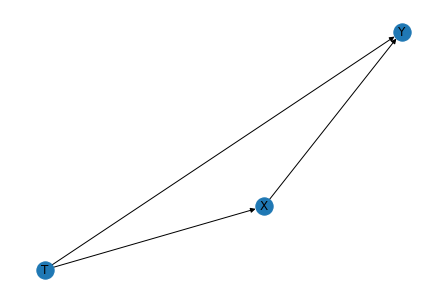

In [78]:
g3 = nx.DiGraph()
g3.add_edge('T','X')
g3.add_edge('X','Y')
g3.add_edge('T','Y')
nx.draw(g3, pos=nx.spiral_layout(g3), with_labels=True)

# g3 = gr.Digraph()
# g3.edge("T","X")
# g3.edge("X","Y")
# g3.edge("T","Y")
# g3

### Simulate DGP

In [157]:
def generate_data_selectionBias(tauprime,N,beta0,beta1):
    T = fn_randomize_treatment(N) # randomly assign treatment
    errX = np.random.normal(0,1,[N,1]) #error for determining X with T
    
    X = beta0*T+errX
    
    err = np.random.normal(0,1,[N,1])
    Yab = tauprime*T + beta1*X + err
    
    return Yab, T, X

In [178]:
np.random.seed(100)
tauprime =2
beta0 = 1.2
beta1 = 0.7
tau3 = tauprime + beta0*beta1
for N in [100,1000]:
    genData = generate_data_selectionBias(tauprime,N,beta0,beta1)
    data3 = pd.DataFrame(np.concatenate((genData[0],genData[1],genData[2]),axis=1))
    data3.columns = ['Y','T','X']
    data3.to_csv('data3n'+str(N)+'.csv')

### Part a): You control for the variable in between the cause-effect path

In [174]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = generate_data_selectionBias(tauprime,N,beta0,beta1)
        model = sm.OLS(Yexp, np.concatenate((T,X),axis=1))
        results = model.fit()
        tauhat = results.params[0]
        se_tauhat = results.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 221.34it/s]


In [175]:
tau0_3 = tau3*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0_3,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.8418252081251025, RMSE=0.8623608546781721, size=0.993
N=1000: bias=-0.8389878683566439, RMSE=0.8410436598662479, size=1.0


### Part b): You do not control for the variable in between the cause-effect path

In [176]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = generate_data_selectionBias(tauprime,N,beta0,beta1)
        model = sm.OLS(Yexp, T)
        results = model.fit()
        tauhat = results.params[0]
        se_tauhat = results.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 221.78it/s]


In [177]:
tau0_3 = tau3*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0_3,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.00476514434616273, RMSE=0.16863735711802091, size=0.049
N=1000: bias=-0.003233578902564277, RMSE=0.053560456004600944, size=0.049


The bias and RMSE from scenario a) are much higher than that for scenatrio b). The size metric also shows the same results. This is because when we condition on the mediator variable between treatment and outcome, you underestimate the effect true tau.  

### Real Life Example

T: College Educated

X: Income

Y: Home Ownership

Suppose we wanted to test the effect of having a college degree on whether or not an individual becomes a homeowner in their lifetime. Those who are educated are more likely to understand the process how to best buy a house within thier budget. However, being college educated also increases your liklihood of having higher income, which also increases your chances of buying a house. Therefore, we have selection bias.